# WDSR

In [1]:
import os
import matplotlib.pyplot as plt

from data import Thermal
from model.wdsr import wdsr_b
from train import WdsrTrainer

%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Number of residual blocks
depth = 32

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [3]:
# Location of model weights (needed for demo)
weights_dir = f'weights/wdsr-b-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [4]:
Thermal_train = Thermal(scale=scale, subset='train', downgrade=downgrade)
Thermal_valid = Thermal(scale=scale, subset='valid', downgrade=downgrade)

In [5]:
train_ds = Thermal_train.dataset(batch_size=16, random_transform=True)
valid_ds = Thermal_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

LR_Image Directory:
data/Thermal_train_LR_bicubic/X4
HR_Image Directory:
data/Thermal_train_HR
LR_Image Directory:
data/Thermal_valid_LR_bicubic/X4
HR_Image Directory:
data/Thermal_valid_HR


## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-32-x4.tar.gz](https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-32-x4` directory containing the weights of the pre-trained model.

In [6]:
trainer = WdsrTrainer(model=wdsr_b(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/wdsr-b-{depth}-x{scale}')

Restoring from .ckpt/wdsr-b-32-x4/ckpt-65
Model restored from checkpoint at step 300000.


In [7]:
# Train WDSR B model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(10),
              steps=100000, 
              evaluate_every=1000, 
              save_best_only=True)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Restoring from .ckpt/wdsr-b-32-x4/ckpt-65
Model restored from checkpoint at step 300000.
301000/100000: loss = 1.637, PSNR = 41.188591 (129.75s)
302000/100000: loss = 0.889, PSNR = 41.475288 (123.37s)


KeyboardInterrupt: 

In [9]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 264000.


In [10]:
# Evaluate model on full validation set
psnr = trainer.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

PSNR = 39.621670


In [11]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [6]:
model = wdsr_b(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [ ]:
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
from model import resolve_single
from utils import load_image, plot_sample
import cv2
import numpy as np
import tensorflow as tf
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
import cv2

def resolve_and_plot(lr_image_path, hr_image_path):
    lr = load_image(lr_image_path)
    lr = cv2.cvtColor(lr, cv2.COLOR_GRAY2BGR)
    hr = load_image(hr_image_path)
    sr = resolve_single(model, lr)
    #print(hr.shape)
    #print(sr.shape)    
    plot_sample(lr, sr, hr)
    mse = tf.keras.losses.MeanSquaredError()
    sr2 = cv2.cvtColor(np.float32(sr), cv2.COLOR_BGR2GRAY)
    ssim_e = ssim(sr2, hr, data_range=hr.max() - hr.min())
    print(ssim_e)
    #err = mse(hr, sr2).numpy()
    #print("The mean square error of the two images is:")
    #print(err)
    

0.9852943030408593


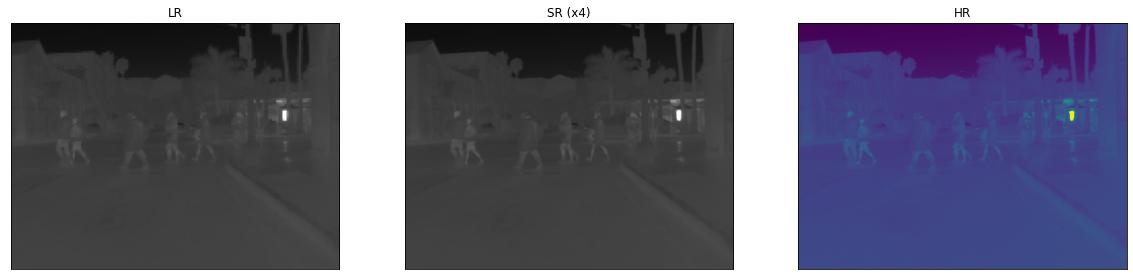

In [8]:
resolve_and_plot('demo/0004x4.png','demo/0004.png')

0.9678256301870908


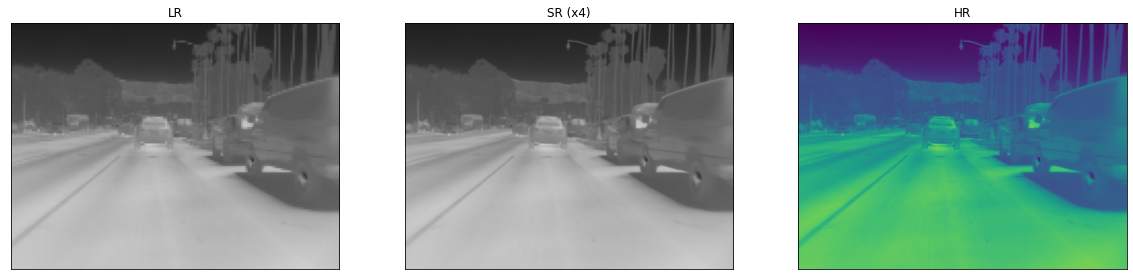

In [9]:
resolve_and_plot('demo/1064x4.png','demo/1064.png')

0.8973779253649764


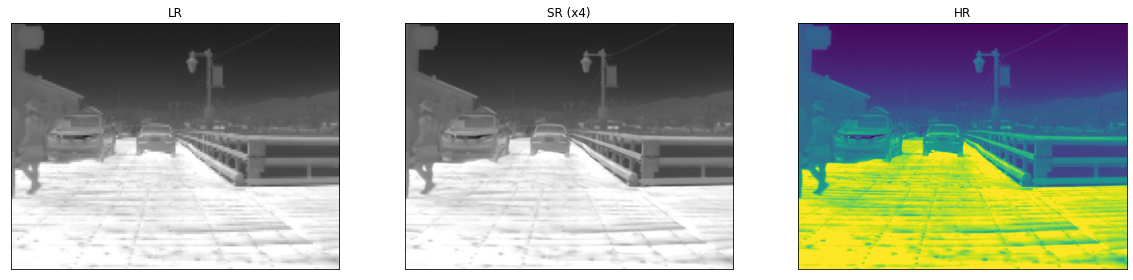

In [10]:
resolve_and_plot('demo/0303x4.png','demo/0303.png')